# Forward simulations of neural mass models

The goal here is to provide characteristic simulations of neural mass model used in the VEP model.  This isn't yet done very well, since we only worked with this reduced form via inference.

In [21]:
%pylab inline
import lib
from scipy.integrate import odeint

Populating the interactive namespace from numpy and matplotlib


/soft/miniconda3/envs/jhub/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['linalg', 'pylab', 'random', 'info', 'power', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Dataset

The full data set is packed in a tarball in the git repo. Let's just load the connectivity matrix for now.

In [89]:
tbz = lib.tarfile.open('trec.tbz')
with tbz.extractfile('./weights.txt') as fd:
    w = np.loadtxt(fd)

We zero the diagonal so that no self connections are via this connectivity matrix, and then keep a small subset of the overall matrix,

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcd8841be48>,
 <matplotlib.image.AxesImage at 0x7fcd912712b0>)

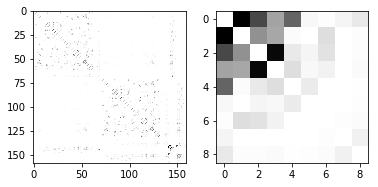

In [100]:
fill_diagonal(w, 0.0)
subplot(121), imshow(w, cmap='binary')

w = w[-9:, -9:]
subplot(122), imshow(w_, cmap='binary')

## Neural mass model

This neural mass model is a set of two DEs in $(x, z)$ representing the slow evolution of a seizure, derived via averaging from the 6D system described in the paper,

$ \dot{x} = I_1 - x^3 - 2 x^2 - z $

$ \dot{z} = \frac{1}{\tau_0} \left[ 4 (x - x_0) - z - k \cdot gx \right] $

The topology of the phase space can be determined from the _nullclines_,

$ \dot{x} \equiv 0 \implies z = I_1 - x^3 - 2 x^2 $

$ \dot{z} \equiv 0 \implies z = 4 (x - x_0) - k \cdot c_{ij} (x_j - x) $

Where these intersect, there is a fixed point, for example.

## Simulation of single neural mass


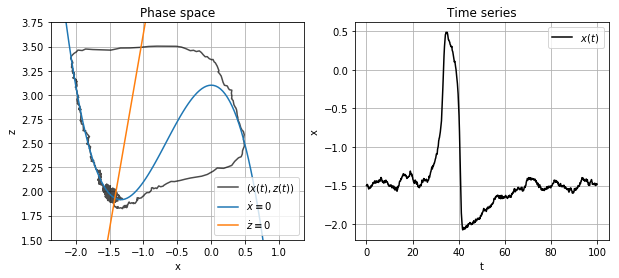

In [105]:
# integrator
def traj(x0,k, xj, tau0, ic, tf=10.0, dt=0.1, sig=1e-2):
    def vf(y, t0):
        x, z = y
        dx = 3.1-x**3-2*x**2-z
        dz = (4*(x-x0)-k*(xj - x)-z)/tau0
        return r_[dx, dz]
    t = r_[:tf:dt]
    y = zeros((len(t), 2)) * nan
    y[0] = ic
    for i in range(t.size - 1):
        y[i + 1] = odeint(vf, y[i], r_[0, dt])[1] + randn(2)*sig
    return t, y

# example parameters
a = -2.4
x0 = -1.9
xj = -1.8
k = 0.05
tau0 = 30.0
xic = -1.8
lsig = -4.5

seed(42)
t, xz = traj(x0,k, xj, tau0, r_[-1.5, 2.0], tf=100, sig=exp(lsig))

figure(figsize=(10, 4))
subplot(121), plot(xz[:, 0], xz[:, 1], 'k', alpha=0.7)
x = r_[-2.2:1.2:100j]; plot(x, 3.1-x**3-2*x**2), plot(x, 4*(x-x0)-k*(xj - x))
legend(('$(x(t), z(t))$', '$\dot{x}\equiv 0$', '$\dot{z}\equiv 0$')), xlabel('x'), ylabel('z'), title('Phase space'), grid(1), ylim([1.5, 3.75])
subplot(122), plot(t, xz[:, 0], 'k'), legend(('$x(t)$',)), grid(1), xlabel('t'), ylabel('x'), title('Time series');

This figure shows a single trajectory for the $(x,z)$ system, starting at the stable fixed point (where the blue & orange lines intersect), noise drives it across the separatrix, causing a single nonlinear excursion in phase space, with a return to the fixed point.

While the excursion is nonlinear, the dynamics around the fixed point are well approximated by linearization.

## Network simulation

The same equations as above, but one node per row in the connectivity matrix, and we use a difference coupling to connect them:

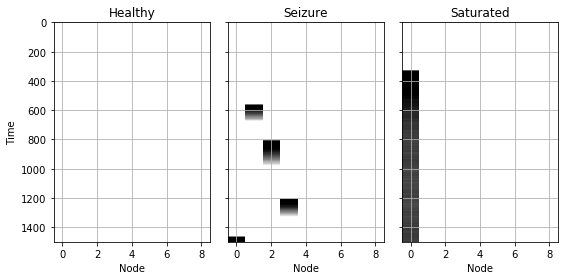

In [115]:
def traj(k, tau0, ic, w, x0, tf=100.0, dt=0.1, sig=1e-2):
    def vf(y):
        x, z = y
        gx = sum(w * (x[:, None] - x), axis=1)
        dx = 3.1-x**3-2*x**2-z
        dz = (4*(x-x0)-k*gx-z)/tau0
        return array([dx, dz])
    t = r_[:tf:dt]
    y = zeros((len(t), 2, w.shape[0])) * nan
    y[0] = ic
    for i in range(t.size - 1):
        y[i + 1] = y[i] + vf(y[i])*dt + randn(2, w.shape[0])*sqrt(dt)*sig
    return t, y

# initial conditions, w/ one node set to enter seizure at simulation startb
ic = r_[-1.5, 2.0][:, newaxis]*ones((2, w.shape[0]))
#ic[1, 0] = -1.8

# SC normalization (w -> 'weights')
w_ = w[w>0]**exp(a)
w_ /= w_.max()

figure(figsize=(8, 4))
# compare 4e-4, 5e-4, 6e-4
titles = 'Healthy', 'Seizure', 'Saturated'
for i, k in enumerate(r_[4, 5, 6]*1e-4/w.shape[0]):
    seed(42)
    t, xz = traj(k, 30.0, ic, w, -1.9, tf=150, dt=0.1, sig=0.01)
    subplot(1, 3, i + 1), imshow(xz[:, 0], aspect='auto', vmin=0, vmax=0.5, cmap='binary', interpolation='none')
    grid(1), ylabel('Time') if i==0 else gca().yaxis.set_ticklabels([]), title(titles[i]), xlabel('Node')
tight_layout()

_Healthy_, _seizure_ and _saturated_ states are produced by varying coupling strength parameter `k`, illustrating bounds on reasonable behavior for this model.  Given patient data, the healthy state is the goal, but data show seizure propagation between network nodes.  The saturated state OTOH is not observed.

While this figure is produced with a single subcritical (= healthy) $x_0$ value for all nodes, in real cases, we expect that there are pathological nodes where the combination of unhealthy $x_0$ values and connectivity lead to spontaneous seizure initiation.

## Parameter recovery

Given the above model, I'd like to be sure we can recover parameters w/o difficulty

In [162]:
%%file fwd-sim-net.stan
functions {
    matrix gen_x(matrix[] dWt, vector[] ic, real sig, real dt, real x0, real k, matrix w) {
        int nt = cols(dWt[1]) + 1;
        int nn = rows(dWt[1]);
        matrix[nn, nt] x;
        matrix[nn, nt] z;
        vector[nn] dx;
        vector[nn] dz;
        vector[nn] gx;
        x[,1] = ic[1];
        z[,1] = ic[2];
        for (t in 1:(nt - 1)) {
            gx = rows_dot_product(w, rep_matrix(x[,t]', nn) - rep_matrix(x[,t], nn));
            dx = 3.1 - x[,t].*x[,t].*x[,t] - 2*x[,t].*x[,t] - z[,t];
            dz = (4*(x[,t] - x0) - k*gx - z[,t])/30.0;
            x[,t+1] = x[,t] + dx*dt + sqrt(dt)*sig*dWt[1][,t];
            z[,t+1] = z[,t] + dz*dt + sqrt(dt)*sig*dWt[2][,t];
        }
        return x;
    }
}
data {
    int nt;
    int nn;
    real tol;
    matrix[nn, nt] x;
    matrix[nn, nn] w; // SC
}
parameters {
    matrix[nn, nt - 1] dWt[2];
    vector[nn] ic[2];
    real sig_;
    real dt_;
    real x0;
    real k_;
}
transformed parameters {
    real sig = 0.01 * exp(0.1 * sig_);
    real dt = 0.1 * exp(0.1 * dt_);
    real k = (1.0e-4 / nn) * exp(0.1 * k_);
    matrix[nn, nt] xh = gen_x(dWt, ic, sig, dt, x0, k, w);
    //print("dt = ", dt, ", sig = ", sig, ", k = ", k);
}
model {
    to_vector(dWt[1]) ~ normal(0, 1);
    to_vector(dWt[2]) ~ normal(0, 1);
    ic[1] ~ normal(-1.5, 1);
    ic[2] ~ normal(2.0, 1);
    sig_ ~ normal(0, 1);
    dt_ ~ normal(0, 1);
    x0 ~ normal(-1.8, 1);
    k_ ~ normal(0, 1);
    to_vector(x) ~ normal(to_vector(xh), tol);
}

Overwriting fwd-sim-net.stan


In [163]:
!. /soft/stan/activate && here=`pwd`; cd $CMDSTAN; make CC=g++ $here/fwd-sim-net

activating stan v2.17.0

--- Translating Stan model to C++ code ---
bin/stanc  /home/duke/src/tvb/vep.stan/fwd-sim-net.stan --o=/home/duke/src/tvb/vep.stan/fwd-sim-net.hpp
Model name=fwd_sim_net_model
Input file=/home/duke/src/tvb/vep.stan/fwd-sim-net.stan
Output file=/home/duke/src/tvb/vep.stan/fwd-sim-net.hpp
DIAGNOSTIC(S) FROM PARSER:


--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -I src -I stan/src -isystem stan/lib/stan_math/ -DEIGEN_NO_DEBUG -DFUSION_MAX_VECTOR_SIZE=12 -DNO_FPRINTF_OUTPUT -pipe -Wl,-rpath,/soft/gcc630/bin -Wl,-rpath,/soft/gcc492/bin  -lpthread  -O3 -o /home/duke/src/tvb/vep.stan/fwd-sim-net src/cmdstan/main.cpp -include /home/duke/src/tvb/vep.stan/fwd-sim-net.hpp stan/lib/stan_math/lib/cvodes_2.9.0/lib/libsund

In [190]:
seed(42); _, xz = traj(5e-4/w.shape[0], 30.0, ic, w, -1.9, tf=150, dt=0.1, sig=0.01)

lib.rdump('fwd-sim-net.R', {
    'w': w,
    'nn': w.shape[0],
    'nt': xz.shape[0],
    'tol': 1e-2,
    'x': xz[:, 0].T
})

In [191]:
%%bash
. /soft/stan/activate
./fwd-sim-net sample save_warmup=1 num_warmup=200 num_samples=200 \
    data file=fwd-sim-net.R \
    output refresh=1 file=fwd-sim-net.csv &> fwd-sim-net.out &

activating stan v2.17.0


Iteration:  25 / 400 [  6%]  (Warmup)


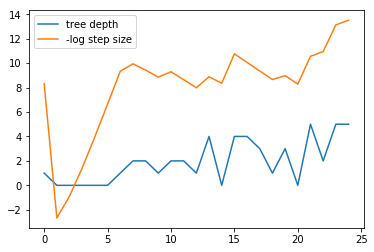

In [193]:
!tail -n1 fwd-sim-net.out
csv = lib.parse_csv('fwd-sim-net.csv')
plot(csv['treedepth__'],label='tree depth')
plot(-log(csv['stepsize__']),label='-log step size')
legend()

## Monte Carlo simulations

_work in progess_

A few questions can be answered via MC simulation:

- How frequent is seizure for otherwise stable node with noise?
- How varied are propagation patterns (such as the middle panel in above figure)?
- Effect of scaling `w**a` on propagation

In [91]:
# init ipcluster via ~/bin/ipcluster 100, w/ 100 engines
import ipyparallel as ipp
rc = ipp.Client()
dv = rc[:]
lbv = rc.load_balanced_view()
ic = r_[-1.5, 2.0][:, newaxis]*ones((2, w.shape[0]))
dv.push({'w': w, 'ic': ic}, block=True);

The function running on the worker is identical to the above, but avoids requiring imports like `from pylab import *`.

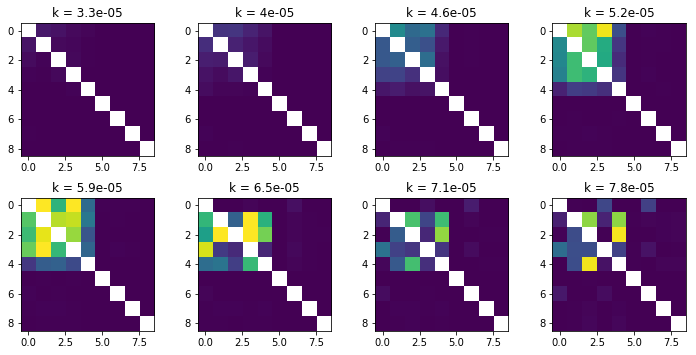

In [108]:
def thunk(args):
    seed_, k_ = args
    import numpy as np
    def traj(k, tau0, ic, w, x0, tf=100.0, dt=0.1, sig=1e-2):
        def vf(y):
            x, z = y
            gx = np.sum(w * (x[:, None] - x), axis=1)
            dx = 3.1-x**3-2*x**2-z
            dz = (4*(x-x0)-k*gx-z)/tau0
            return np.array([dx, dz])
        t = np.r_[:tf:dt]
        y = np.zeros((len(t), 2, w.shape[0])) * np.nan
        y[0] = ic
        for i in range(t.size - 1):
            y[i + 1] = y[i] + vf(y[i])*dt + np.random.randn(2, w.shape[0])*np.sqrt(dt)*sig
        return t, y
    np.random.seed(seed_)
    t, xz = traj(k_*1e-4/w.shape[0], 30.0, ic, w, -1.9, tf=150, dt=0.1, sig=0.01)
    txz = t[:,None]*(xz[:,0]>0)
    return np.array([_[_>0].mean() for _ in txz.T])

figure(figsize=(10, 5))
for l, k in enumerate(r_[3.0:7.0:8j]):
    pd = np.array(lbv.map_sync(thunk, [(_, k) for _ in range(1000)]))
    pp = np.zeros(w.shape)
    for i in range(w.shape[0]):
        for j in range(w.shape[0]):
            if i == j:
                pp[i, j] = np.nan
            else:
                pp[i, j] = (pd[:, j] > pd[:, i]).mean()
    subplot(2, 4, l + 1)
    imshow(pp, interpolation='none', vmin=0, vmax=0.25)
    title('k = %0.2g' % (k*1e-4/w.shape[0], ))
tight_layout()

This shows variation (and asymmetry) in propagation patterns by varying `k`.  Different patterns would be biased by symmetry breaking of `x0`.